# Imports, Definitions, and Instantiating the overlay

In [1]:
import numpy as np
import time
import pynq
from pynq import PL, Overlay, DefaultIP, allocate
from fpbinary import FpBinary, OverflowEnum, RoundingEnum
import matplotlib.pyplot as plt

FP16_15 = lambda x: FpBinary(int_bits=1, frac_bits=15, signed=True, value=x)
FP16_25 = lambda x: FpBinary(int_bits=-9, frac_bits=25, signed=True, value=x)
FP16_23 = lambda x: FpBinary(int_bits=-7, frac_bits=23, signed=True, value=x)
n_res = 2048

Create a driver

In [2]:
class ResonatorDDSIP(DefaultIP):
    toneinc_offset = 0x1000
    phase0_offset = 0x2000

    def __init__(self, description):
        """

        Note the axilite memory space is
        0x1000 ~
        0x1fff : Memory 'toneinc_V' (256 * 128b)
                 Word 4n   : bit [31:0] - toneinc_V[n][31: 0]
                 Word 4n+1 : bit [31:0] - toneinc_V[n][63:32]
                 Word 4n+2 : bit [31:0] - toneinc_V[n][95:64]
                 Word 4n+3 : bit [31:0] - toneinc_V[n][127:96]
        0x2000 ~
        0x2fff : Memory 'phase0_V' (256 * 128b)
                 Word 4n   : bit [31:0] - phase0_V[n][31: 0]
                 Word 4n+1 : bit [31:0] - phase0_V[n][63:32]
                 Word 4n+2 : bit [31:0] - phase0_V[n][95:64]
                 Word 4n+3 : bit [31:0] - phase0_V[n][127:96]
        """
        super().__init__(description=description)

    bindto = ['MazinLab:mkidgen3:resonator_dds:0.9']

    @staticmethod
    def _checkgroup(group_ndx):
        if group_ndx < 0 or group_ndx > 255:
            raise ValueError('group_ndx must be in [0,255]')

    def read_group(self, offset, group_ndx):
        """Read the numbers in group from the core and convert them from binary data to python numbers"""
        self._checkgroup(group_ndx)
        signed = offset == self.toneinc_offset
        vals = [self.read(offset + 16 * group_ndx + 4 * i) for i in range(4)]  # 2 16bit values each
        ret = [float(FpBinary(1, 15, signed=signed, bit_field=(v >> (16 * i)) & 0xffff))
               for v in vals for i in (0, 1)]
        # print(f"Read {bin(vals[0]&0xffff)} from the first address.")
        return ret

    def write_group(self, offset, group_ndx, group):
        """Convert the numbers in the group from python data to binary data and load it into the core"""
        self._checkgroup(group_ndx)
        if len(group) != 8:
            raise ValueError('len(group)!=8')
        signed = offset == self.toneinc_offset
        bits = 0
        fixedgroup = [FpBinary(int_bits=1, frac_bits=15, signed=signed, value=g) for g in group]
        for i, (g0, g1) in enumerate(zip(*[iter(fixedgroup)] * 2)):  #take them by twos
            bits |= ((g1.__index__() << 16) | g0.__index__()) << (32 * i)
        data = bits.to_bytes(32, 'little', signed=False)
        self.write(offset + 16 * group_ndx, data)

    def toneinc(self, res):
        """ Retrieve the tone increment for a particular resonator """
        return self.read_group(self.toneinc_offset, res // 8)[res % 8]

    def phase0(self, res):
        """ Retrieve the phase offset for a particular resonator """
        return self.read_group(self.phase0_offset, res // 8)[res % 8]

    @property
    def toneincs(self):
        return [v for g in range(256) for v in self.read_group(self.toneinc_offset, g)]

    @toneincs.setter
    def toneincs(self, toneincs):
        if len(toneincs) != 2048:
            raise ValueError('len(toneincs)!=2048')
        if min(toneincs) < -1 or max(toneincs) >= 1:
            raise ValueError('Tone increments must be in [-1,1)')
        for i in range(256):
            self.write_group(self.toneinc_offset, i, toneincs[i * 8:i * 8 + 8])

    @property
    def phase0s(self):
        return [v for g in range(256) for v in self.read_group(self.phase0_offset, g)]

    @phase0s.setter
    def phase0s(self, phase0s):
        if len(phase0s) != 2048:
            raise ValueError('len(phase0s)!=2048')
        if min(phase0s) < 0 or max(phase0s) > 1:
            raise ValueError('Phase offsets must be in [0,1]')
        for i in range(256):
            self.write_group(self.phase0_offset, i, phase0s[i * 8:i * 8 + 8])


Create some helper functions to send and recieve data

In [3]:
n_packets_rcvd, n_packets_sent, pptx, input_buffer = 0, 0, None, None
next_sample_send=0

def prep_buffers(ntx=16, n_res=2048):
    global pptx, input_buffer, output_buffer
    pptx = ntx

    try:
        # Close buffers if they are open
        input_buffer.close()
        output_buffer.close()
    except (NameError,AttributeError):
        pass

    # Create the buffers
    input_buffer = allocate(shape=(n_res * 2 * pptx,), dtype=np.uint16)  # 2048 I & Q
    output_buffer = allocate(shape=(n_res * 2,), dtype=np.uint16)


def packet_to_buffer(packet, fpgen=FP16_15):
    if fpgen is None:
        ibits = [np.uint16(x) for x in packet.real]
        qbits = [np.uint16(x) for x in packet.imag]
    else:
        ibits = [fpgen(x).__index__() for x in packet.real]
        qbits = [fpgen(x).__index__() for x in packet.imag]
    data = np.zeros(2 * packet.size, dtype=np.uint16)
    data[::2] = ibits
    data[1::2] = qbits
    return data


def packet_from_buffer(buffer, fpformat=(-9,25)):
    packet = np.zeros(buffer.size // 2, dtype=np.complex128)
    
    ibits = buffer[0::2]
    qbits = buffer[1::2]

    if fpformat is None:
        fp = lambda x: int(x)
    else:
        fp = lambda x: FpBinary(int_bits=fpformat[0], frac_bits=fpformat[1], signed=True, bit_field=int(x))
    packet.real = [float(fp(x)) for x in ibits]
    packet.imag = [float(fp(x)) for x in qbits]
    return packet


def txrx(dma, comb, nper, packets_out, n_total_packets=None, packet_latency=1, in_per_out=2,
         txfp=FP16_15, rxfp=(-9,25), wait=True, show=False):
    global n_packets_rcvd, n_packets_sent, pptx, input_buffer, next_sample_send
    
    if n_total_packets is None:
        n_total_packets=comb.size//256//8
    
    
    prep_buffers(nper)
    n_loop=(n_total_packets - n_packets_sent) // pptx
    
    print(f'Will send {(n_total_packets - n_packets_sent)} packets in {n_loop} iterations')

    for i in range(n_loop):
        
        #Send data
        n_to_send = pptx * n_res
        data = comb.ravel()[next_sample_send:next_sample_send + n_to_send]
        input_buffer[:] = packet_to_buffer(data, fpgen=txfp)
        
        dma.sendchannel.transfer(input_buffer)

        if wait:
            if show:
                print(f"Sent {pptx}, waiting.")
            dma.sendchannel.wait()
        next_sample_send += n_to_send
        n_packets_sent = next_sample_send // n_res
        
        #How many are are available to be recieved
        pending = n_packets_sent//in_per_out - n_packets_rcvd - packet_latency
        
        if show:
            print(f"Sent: {n_packets_sent}  Pending: {pending}")
            
        for i in range(pending):
            if show:
                print(f"Receiving packet {n_packets_rcvd}")
            dma.recvchannel.transfer(output_buffer)
            if wait:
                dma.recvchannel.wait()
            packets_out[n_packets_rcvd] = packet_from_buffer(output_buffer, fpformat=rxfp)
            n_packets_rcvd += 1

        if show:
            print(f"Received: {n_packets_rcvd}.")

def dds(p):
    return np.cos(np.pi*p)+np.sin(np.pi*p)*1j

Load the overlay and extract the dma and ip core

In [4]:
ol = Overlay('/home/xilinx/overlayfiles/test_ddc_control/test_ddc.bit',ignore_version=True)
ol.download()
dma=ol.axi_dma_0
ddc_core=ol.resonator_dds_0
print(f"PL Bitfile: {PL.bitfile_name}\nPL Timestamp: {PL.timestamp}\n"
      f"Overlay timestamp: {ol.timestamp}  Loaded: {ol.is_loaded()}")

PL Bitfile: /home/xilinx/overlayfiles/test_ddc_control/test_ddc.bit
PL Timestamp: 2020/5/14 6:36:59 +158594
Overlay timestamp: 2020/5/14 6:36:59 +158594  Loaded: True


## Configure the core

In [5]:
phase0s=np.zeros(2048)
toneincs=np.zeros(2048)

In [6]:
toneincs[:]=0.0
phase0s[:]=0.25
ddc_core.toneincs=toneincs
ddc_core.phase0s=phase0s  

Check that we've loaded the core

In [7]:
print('Reading toneinc group 0',ddc_core.read_group(ddc_core.toneinc_offset, 0))
print('Reading toneinc group 1',ddc_core.read_group(ddc_core.toneinc_offset, 1))
print('Reading toneinc group 255',ddc_core.read_group(ddc_core.toneinc_offset, 255))
print('Reading phase offset group 0',ddc_core.read_group(ddc_core.phase0_offset, 0))
print('Reading phase offset group 255',ddc_core.read_group(ddc_core.phase0_offset, 255))

Reading toneinc group 0 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Reading toneinc group 1 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Reading toneinc group 255 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Reading phase offset group 0 [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Reading phase offset group 255 [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]


Start the core for versions of the IP that don't use ap_crtl_none

In [8]:
try:
    ddc_core.register_map.CTRL.AUTO_RESTART=True
    ddc_core.register_map.CTRL.AP_START=True
except Exception as e:
    print(e)
ddc_core.register_map

/usr/local/lib/python3.6/dist-packages/pynq/registers.py:422: UserWarning: Unsupported register size 4096 for register Memory_toneinc_V
  v[2], k
/usr/local/lib/python3.6/dist-packages/pynq/registers.py:422: UserWarning: Unsupported register size 4096 for register Memory_phase0_V
  v[2], k


RegisterMap {
  CTRL = Register(AP_START=1, AP_DONE=0, AP_IDLE=0, AP_READY=0, RESERVED_1=0, AUTO_RESTART=1, RESERVED_2=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED=0)
}

## Send the data & compute expected outputs
Send in groups of 6 packets, 6*2048 samples, 1536 transactions, overlay has length 2048 fifos bracketing the core 

### Prepare data to send


In [9]:
n_packets=200  #how many sets of 8x256 samples? Need some maximum number of things for sending and recieving
npack=6 # how many we send at a time

Set up data so we can send the bits 0 on real and 8192 on imaginary for the first 1024 channels and 0 for the last 1024.

In [10]:
data=(np.ones(2048)*8192j+0)[np.newaxis,:]*np.ones(n_packets)[:,np.newaxis]
data[:,1024:]=0

Output and expected output array

In [11]:
packets_out=np.zeros((data.shape[0], n_res), dtype=np.complex64)
expected=np.zeros_like(data)

Make it easy to send different phase offsets to see if the core responds.

In [12]:
phase0_progression=np.array([.25,.5,0,1]) #note that 0 should result in out=in and 0.5 should result in a swap of real and imag. 

This things step by step to allow arming the System ILA

In [13]:
#what data are we sending
i=0
sl=slice(n_packets_sent, n_packets_sent+npack)
#load phase offsets again
phase0s[:]=phase0_progression[i]
ddc_core.phase0s=phase0s
#compute the expected output
expected[sl,:]=data[sl,:]*dds(phase0_progression[i])
#send and recieve the data to the core. With txfp and rxfp set to none numbers will just be as if they were uint16
# packet latenc needs to be 1 since the core has about 27 cycles of latency so the last packet's last 
# sample will always be stuck in the coret
txrx(dma, data, 6, packets_out, n_total_packets=npack*(i+1), packet_latency=1, wait=True, show=True, 
     txfp=None, rxfp=None, in_per_out=1)

Will send 6 packets in 1 iterations
Sent 6, waiting.
Sent: 6  Pending: 5
Receiving packet 0
Receiving packet 1
Receiving packet 2
Receiving packet 3
Receiving packet 4
Received: 5.


In [14]:
#what data are we sending
i=1
sl=slice(n_packets_sent, n_packets_sent+npack)
#load phase offsets again
phase0s[:]=phase0_progression[i]
ddc_core.phase0s=phase0s
#compute the expected output
expected[sl,:]=data[sl,:]*dds(phase0_progression[i])
#send and recieve the data to the core. With txfp and rxfp set to none numbers will just be as if they were uint16
# packet latenc needs to be 1 since the core has about 27 cycles of latency so the last packet's last 
# sample will always be stuck in the coret
txrx(dma, data, 6, packets_out, n_total_packets=npack*(i+1), packet_latency=1, wait=True, show=True, 
     txfp=None, rxfp=None, in_per_out=1)

Will send 6 packets in 1 iterations
Sent 6, waiting.
Sent: 12  Pending: 6
Receiving packet 5
Receiving packet 6
Receiving packet 7
Receiving packet 8
Receiving packet 9
Receiving packet 10
Received: 11.


In [15]:
#what data are we sending
i=2
sl=slice(n_packets_sent, n_packets_sent+npack)
#load phase offsets again
phase0s[:]=phase0_progression[i]
ddc_core.phase0s=phase0s
#compute the expected output
expected[sl,:]=data[sl,:]*dds(phase0_progression[i])
#send and recieve the data to the core. With txfp and rxfp set to none numbers will just be as if they were uint16
# packet latenc needs to be 1 since the core has about 27 cycles of latency so the last packet's last 
# sample will always be stuck in the coret
txrx(dma, data, 6, packets_out, n_total_packets=npack*(i+1), packet_latency=1, wait=True, show=True, 
     txfp=None, rxfp=None, in_per_out=1)

Will send 6 packets in 1 iterations
Sent 6, waiting.
Sent: 18  Pending: 6
Receiving packet 11
Receiving packet 12
Receiving packet 13
Receiving packet 14
Receiving packet 15
Receiving packet 16
Received: 17.


In [16]:
#what data are we sending
i=3
sl=slice(n_packets_sent, n_packets_sent+npack)
#load phase offsets again
phase0s[:]=phase0_progression[i]
ddc_core.phase0s=phase0s
#compute the expected output
expected[sl,:]=data[sl,:]*dds(phase0_progression[i])
#send and recieve the data to the core. With txfp and rxfp set to none numbers will just be as if they were uint16
# packet latenc needs to be 1 since the core has about 27 cycles of latency so the last packet's last 
# sample will always be stuck in the coret
txrx(dma, data, 6, packets_out, n_total_packets=npack*(i+1), packet_latency=1, wait=True, show=True, 
     txfp=None, rxfp=None, in_per_out=1)

Will send 6 packets in 1 iterations
Sent 6, waiting.
Sent: 24  Pending: 6
Receiving packet 17
Receiving packet 18
Receiving packet 19
Receiving packet 20
Receiving packet 21
Receiving packet 22
Received: 23.


In [36]:
expected/=2 #The core (should be) shifting the binary point from -9 to -7. I'm not 100% about this, but it is a division by 2 error at best and not the root issue!

## Look at results
Real is blue, imaginary orange

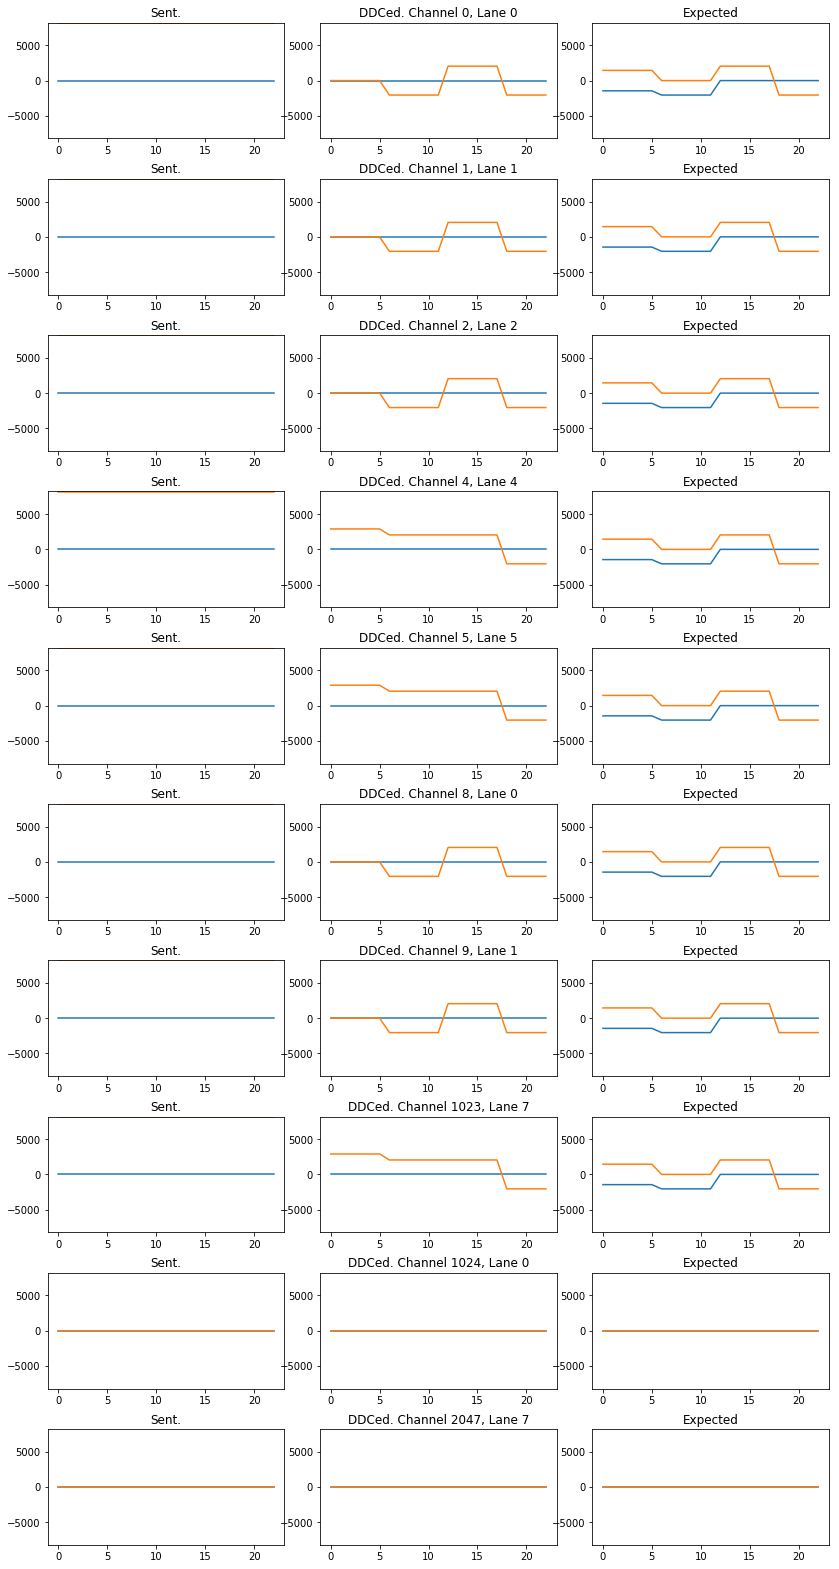

In [41]:
n=n_packets_rcvd #only plot data that came out
res_plot=[0,1,2,4,5,8,9,1023,1024,2047]  #which channels to plot
_,axes = plt.subplots(len(res_plot),3,figsize=(14,2.8*len(res_plot)))
for i,(res, raw, ddc, exp) in enumerate(zip(res_plot, data[:n,res_plot].T,packets_out[:n,res_plot].T,expected[:n,res_plot].T)):
    plt.sca(axes[i,0])
    plt.plot(raw.real)
    plt.plot(raw.imag)
    plt.title(f"Sent.")
    plt.ylim(-8200,8200)
    plt.sca(axes[i,1])
    plt.plot(ddc.real.astype(np.int16))
    plt.plot(ddc.imag.astype(np.int16))
    plt.title(f"DDCed. Channel {res}, Lane {res%8}")
    plt.ylim(-8200,8200)
    plt.sca(axes[i,2])
    plt.plot(exp.real)
    plt.plot(exp.imag)
    plt.ylim(-8200,8200)
    plt.title(f"Expected")
plt.subplots_adjust(wspace=.15, hspace=.35)